source: https://www.neonscience.org/resources/learning-hub/tutorials/create-hillshade-py

# Hillshade using elevation model (Optional)

In this part of lesson we will learn how to create a hillshade from a terrain raster in Python, and demonstrates a few options for visualizing lidar-derived Digital Elevation Models. (Source:[  neonscience.org](https://www.neonscience.org/resources/learning-hub/tutorials/create-hillshade-py))

### Objectives

After completing this tutorial, you will be able to:

* Understand how to read in and visualize Lidar elevation models (DTM, DSM) in Python
* Plot a contour map of the DTM
* Create a hillshade from the DTM
* Calculate and plot Canopy Height along with hillshade and elevation

### Install Python Packages

* **gdal** 
* **rasterio**
* **requests** 

### Download Data

For this lesson, we will read in Digital Terrain Model (DTM) data collected at NEON's <a href="https://www.neonscience.org/field-sites/teak" target="_blank">Lower Teakettle (TEAK)</a> site in California. This data is downloaded in the first part of the tutorial, using the Python `requests` package.

First, let's import the required packages:

In [1]:
import os
import numpy as np
import requests
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt

## Read in the datasets
### Download Lidar Elevation Models from TEAK

To start, we will download the NEON Elevation Models (DTM and DSM) which are provided in geotiff (.tif) format. Use the `download_url` function below to download the data directly from the cloud storage location (<a href="https://data.neonscience.org/data-products/DP3.30024.001" target="_blank">Elevation - LiDAR</a>).



In [2]:
# Getting the data from web resource

# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

# define the urls for downloading the Aspect and NDVI geotiff tiles
dtm_url = "https://storage.googleapis.com/neon-aop-products/2021/FullSite/D17/2021_TEAK_5/L3/DiscreteLidar/DTMGtif/NEON_D17_TEAK_DP3_320000_4092000_DTM.tif"
dsm_url = "https://storage.googleapis.com/neon-aop-products/2021/FullSite/D17/2021_TEAK_5/L3/DiscreteLidar/DSMGtif/NEON_D17_TEAK_DP3_320000_4092000_DSM.tif"

# download the raster data using the download_url function
download_url(dtm_url,'.\data')
download_url(dsm_url,'.\data')

# read downloaded data
dtm_dataset = rio.open(os.path.join('.\data','NEON_D17_TEAK_DP3_320000_4092000_DTM.tif'))
dtm_data = dtm_dataset.read(1)

###  Calculate Hillshade

Hillshade is used to visualize the hypothetical illumination value (from 0-255) of each pixel on a surface given a specified light source. To calculate hillshade, we need the zenith (altitude) and azimuth of the illumination source, as well as the slope and aspect of the terrain. The formula for hillshade is:

$$Hillshade = 255.0 * (( cos(zenith_I)*cos(slope_T))+(sin(zenith_I)*sin(slope_T)*cos(azimuth_I-aspect_T))$$

Where all angles are in radians. 

You can read more about how hillshades work, [here](https://pro.arcgis.com/en/pro-app/3.0/tool-reference/3d-analyst/how-hillshade-works.htm#).  

In [16]:
# Function to compute hillshade from elevation data
def hillshade(elevation_data, azimuth_angle, sun_elevation):
    # Adjust the azimuth to fit the mathematical standard (clockwise from north)
    azimuth_angle = 360.0 - azimuth_angle
    
    # Calculate the gradient in both x and y directions
    gradient_x, gradient_y = np.gradient(elevation_data)
    
    # Calculate the slope and aspect of the terrain
    slope_angle = np.pi / 2.0 - np.arctan(np.sqrt(gradient_x**2 + gradient_y**2))
    aspect_angle = np.arctan2(-gradient_x, gradient_y)
    
    # Convert azimuth and sun altitude to radians
    azimuth_in_radians = azimuth_angle * np.pi / 180.0
    sun_elevation_in_radians = sun_elevation * np.pi / 180.0
    
    # Compute the hillshade using the formula
    hillshade_values = (np.sin(sun_elevation_in_radians) * np.sin(slope_angle) +
                        np.cos(sun_elevation_in_radians) * np.cos(slope_angle) *
                        np.cos(azimuth_in_radians - np.pi / 2.0 - aspect_angle))
    
    # Normalize the hillshade values to a 0-255 range
    hillshade_normalized = 255 * (hillshade_values + 1) / 2
    
    return hillshade_normalized


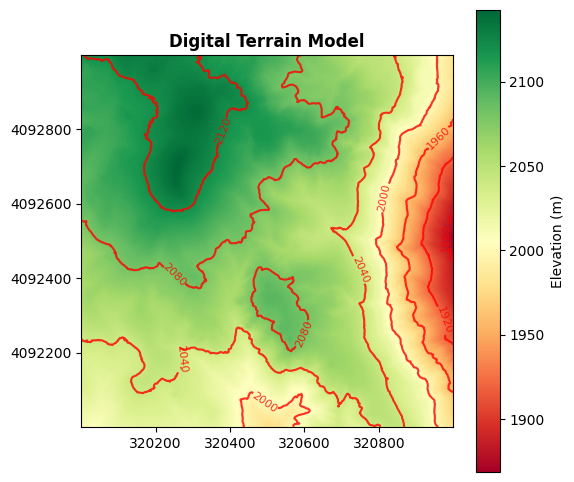

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dtm_map = show(dtm_dataset,title='Digital Terrain Model',ax=ax);
show(dtm_dataset,contour=True, ax=ax); #overlay the contours
im = dtm_map.get_images()[0]
fig.colorbar(im, label = 'Elevation (m)', ax=ax) # add a colorbar
ax.ticklabel_format(useOffset=False, style='plain') # turn off scientific notation

Now that we have a function to generate hillshade, we need to read in the DTM raster using rasterio and then calculate hillshade using the `hillshade` function. We can then plot both.

In [5]:
# Use hillshade function on the DTM data array
hs_data = hillshade(dtm_data,225,45)

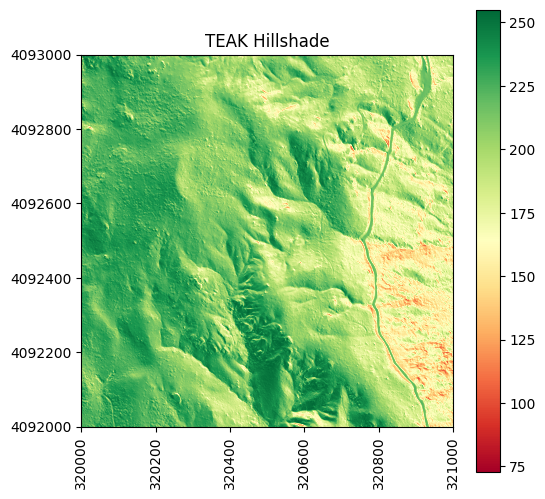

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ext = [dtm_dataset.bounds.left, dtm_dataset.bounds.right, dtm_dataset.bounds.bottom, dtm_dataset.bounds.top]
plt.imshow(hs_data,extent=ext)
plt.colorbar(); plt.set_cmap('RdYlGn'); 
plt.title('TEAK Hillshade')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

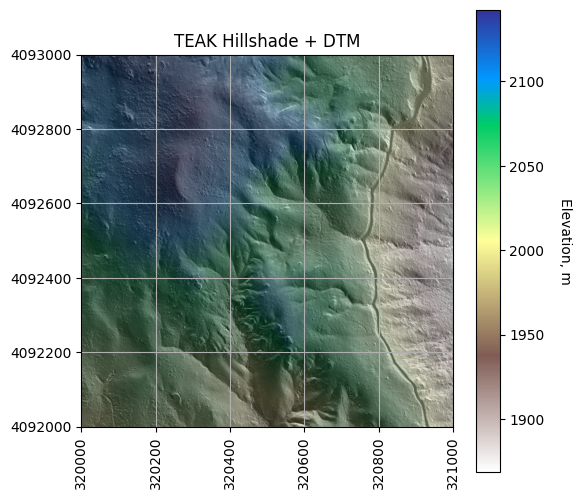

In [7]:
# Overlay transparent hillshade on DTM:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
im1 = plt.imshow(dtm_data,cmap='terrain_r',extent=ext); 
cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(hs_data,cmap='Greys',alpha=0.8,extent=ext); #plt.colorbar()
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
plt.grid('on'); # plt.colorbar(); 
plt.title('TEAK Hillshade + DTM');

### Calculate Canopy Height using raster-raster operations

Canopy Height can be simply calculated by subtracting the Digital Terrain Model from the Digital Surface Model. First, read in the DSM data set, which we previously downloaded into the data folder.

In [8]:
dsm_dataset = rio.open(os.path.join('.\data','NEON_D17_TEAK_DP3_320000_4092000_DSM.tif'))
dsm_data = dsm_dataset.read(1)

In [9]:
# calculate CHM by differencing the terrain model (DTM) from the surface model (DSM):
chm_data = dsm_data - dtm_data;

Plot the Canopy Height Model for reference:

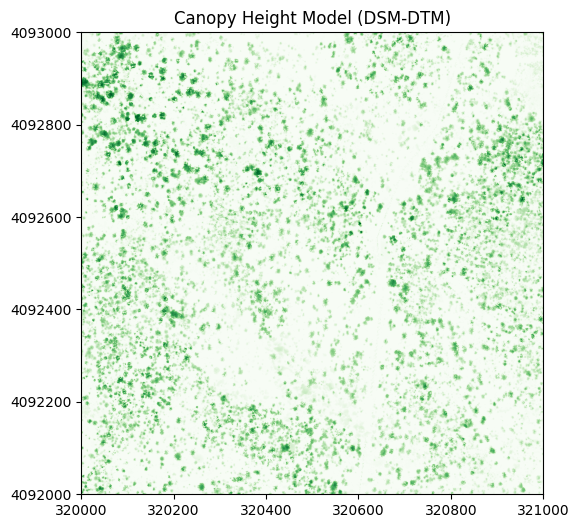

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
im1 = plt.imshow(chm_data,cmap='Greens',extent=ext); 
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
ax.set_title('Canopy Height Model (DSM-DTM)');

Finally, we can make a plot to bring together all of these visualizations from earlier in the tutorial.

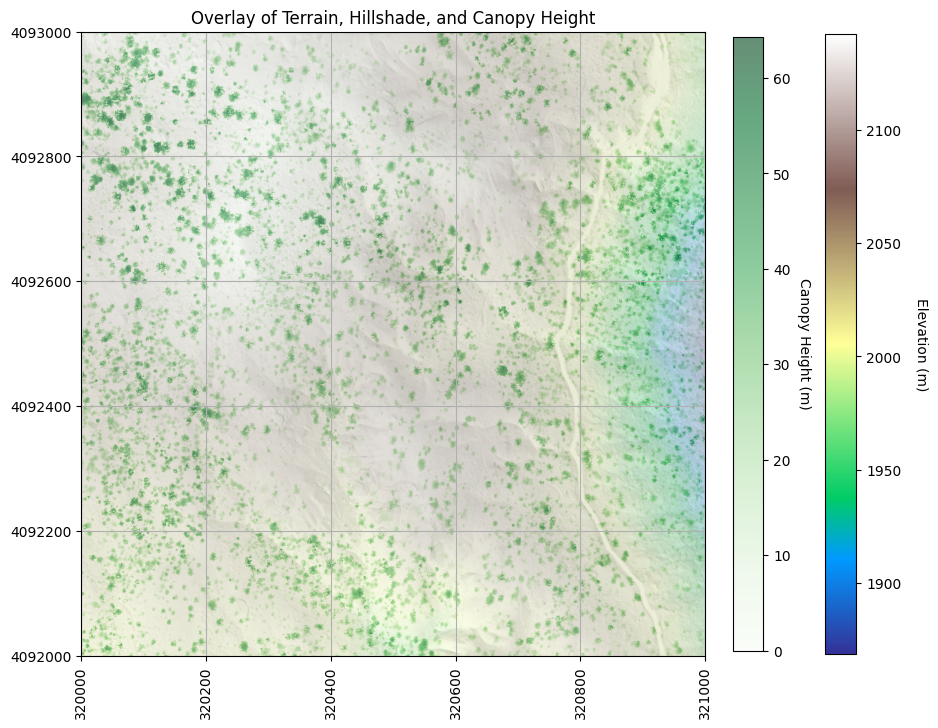

In [11]:
# Overlay hillshade on top of the DTM with transparency:
fig, ax = plt.subplots(figsize=(10, 10))

# Display DTM data using a terrain colormap
terrain_image = ax.imshow(dtm_data, cmap='terrain', extent=ext)
terrain_colorbar = plt.colorbar(terrain_image, fraction=0.04, pad=0.08, ax=ax)
terrain_colorbar.set_label('Elevation (m)', rotation=270, labelpad=20)

# Add hillshade layer with partial transparency
hillshade_image = ax.imshow(hs_data, cmap='gray', alpha=0.5, extent=ext)

# Display canopy height data with transparency
canopy_image = ax.imshow(chm_data, cmap='Greens', alpha=0.6, extent=ext)
canopy_colorbar = plt.colorbar(canopy_image, fraction=0.045, pad=0.04, ax=ax)
canopy_colorbar.set_label('Canopy Height (m)', rotation=270, labelpad=15)

# Disable scientific notation for axis ticks and rotate x-axis labels
ax.ticklabel_format(useOffset=False, style='plain')
plt.setp(ax.get_xticklabels(), rotation=90)

# Add a grid and title to the plot
ax.grid(True)
plt.title('Overlay of Terrain, Hillshade, and Canopy Height')

plt.show()
